In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
df=pd.read_csv('train.csv' ,encoding='unicode_escape')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [7]:
df.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [8]:
df['sentiment'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
data=df[['text','sentiment']]

In [11]:
data.duplicated().sum()

0

In [12]:
data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [84]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.lang.en import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import re,string,unicodedata
from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score ,roc_auc_score,f1_score,confusion_matrix

In [40]:
data.isna().sum() # Checking for nan Values

sentiment     0
clean_text    0
lower         0
punc          0
dtype: int64

In [27]:
data.dropna(inplace=True)

C:\Users\Admin\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


In [128]:
data=data[data['sentiment']!='neutral']

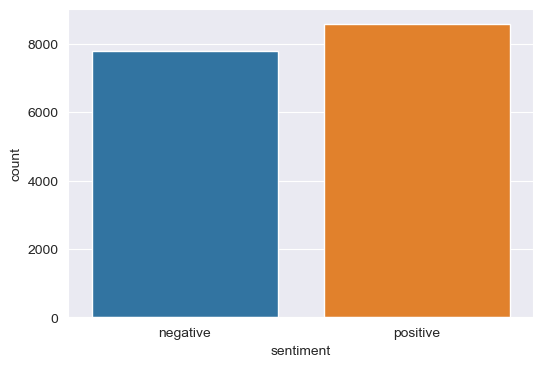

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(x=data.sentiment, data=data)
plt.show()

In [130]:
def clean_text(text):
    text = str(text).lower() ## Make text lowercase
    text = re.sub('\[.*?\]', '', text) ## remove any sequence of characters in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) ## remove links
    text = re.sub('<.*?>+', '', text) ## remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) ## remove punctuation
    text = re.sub('\n', '', text) ## remove newline characters 
    text = re.sub('\w*\d\w*', '', text) ## remove words containing numbers
    text = re.sub(r'[^a-z/A-Z/0-9/ ]', '', text)
    return text

In [131]:
data['clean_text'] = data['text'].apply(clean_text)
data.head()

KeyError: 'text'

In [132]:
stop_words = stopwords.words('english')
more_stopwords = ['s','m','u','im','ye','id','atg','na','ta','gon','wan']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
data['clean_text'] = data['clean_text'].apply(remove_stopwords)
data.head()

C:\Users\Admin\AppData\Local\Temp/ipykernel_17176/3243052291.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['clean_text'].apply(remove_stopwords)


,sentiment,clean_text,lower,punc,tokenized,lemmatized,stemmed
1,negative,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego
2,negative,boss bullying,boss bullying,boss bullying,boss bullying,bos bulli,boss bulli
3,negative,interview leave alone,interview leave alone,interview leave alone,interview leave alone,interview leav alon,interview leav alon
4,negative,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,son couldnt put releas alreadi bought,son couldnt put releas alreadi bought
6,positive,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feed babi fun smile coo,feed babi fun smile coo


In [133]:
data = data.drop('text', axis=1)
data.head()

KeyError: "['text'] not found in axis"

In [134]:
data["lower"] = data["clean_text"].map(lambda x: x.lower())

C:\Users\Admin\AppData\Local\Temp/ipykernel_17176/3384335548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["lower"] = data["clean_text"].map(lambda x: x.lower())


In [135]:
# data['punc'] = data['lower'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
# data.head()
data['tokenized'] = data['lower'].apply(word_tokenize)
data["tokenized"] = data.tokenized.apply(lambda x: " ".join([w for w in x]))
data.head()

C:\Users\Admin\AppData\Local\Temp/ipykernel_17176/1175079877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokenized'] = data['lower'].apply(word_tokenize)
C:\Users\Admin\AppData\Local\Temp/ipykernel_17176/1175079877.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["tokenized"] = data.tokenized.apply(lambda x: " ".join([w for w in x]))


,sentiment,clean_text,lower,punc,tokenized,lemmatized,stemmed
1,negative,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego
2,negative,boss bullying,boss bullying,boss bullying,boss bullying,bos bulli,boss bulli
3,negative,interview leave alone,interview leave alone,interview leave alone,interview leave alone,interview leav alon,interview leav alon
4,negative,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,son couldnt put releas alreadi bought,son couldnt put releas alreadi bought
6,positive,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feed babi fun smile coo,feed babi fun smile coo


In [136]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [137]:
data['stemmed'] = data['tokenized'].apply(stemm_text)
data.head()

C:\Users\Admin\AppData\Local\Temp/ipykernel_17176/3505889545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stemmed'] = data['tokenized'].apply(stemm_text)


,sentiment,clean_text,lower,punc,tokenized,lemmatized,stemmed
1,negative,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego
2,negative,boss bullying,boss bullying,boss bullying,boss bullying,bos bulli,boss bulli
3,negative,interview leave alone,interview leave alone,interview leave alone,interview leave alone,interview leav alon,interview leav alon
4,negative,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,son couldnt put releas alreadi bought,son couldnt put releas alreadi bought
6,positive,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feed babi fun smile coo,feed babi fun smile coo


In [138]:
lemmatizer = WordNetLemmatizer()
def lemm_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [139]:
data['lemmatized']= data.stemmed.apply(lemm_text)
data.sample(n=7)

C:\Users\Admin\AppData\Local\Temp/ipykernel_17176/3481996651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lemmatized']= data.stemmed.apply(lemm_text)


,sentiment,clean_text,lower,punc,tokenized,lemmatized,stemmed
12172,negative,odd tried call mitchel musso dosent work,odd tried call mitchel musso dosent work,odd tried call mitchel musso dosent work,odd tried call mitchel musso dosent work,odd tri call mitchel musso dosent work,odd tri call mitchel musso dosent work
643,negative,available area would,available area would,available area would,available area would,avail area would,avail area would
1778,negative,missing nathan bccg already best friends tried...,missing nathan bccg already best friends tried...,missing nathan bccg already best friends tried...,missing nathan bccg already best friends tried...,miss nathan bccg alreadi best friend tri visit...,miss nathan bccg alreadi best friend tri visit...
8918,negative,sigh always disappoint people get way everyon...,sigh always disappoint people get way everyon...,sigh always disappoint people get way everyone...,sigh always disappoint people get way everyone...,sigh alway disappoint peopl get way everyon mi...,sigh alway disappoint peopl get way everyon mi...
5744,negative,miss youuu wish dodging semis,miss youuu wish dodging semis,miss youuu wish dodging semis,miss youuu wish dodging semis,miss youuu wish dodg semi,miss youuu wish dodg semi
14124,positive,awesome take look home,awesome take look home,awesome take look home,awesome take look home,awesom take look home,awesom take look home
6859,positive,yes siri acquired master arts christian minis...,yes siri acquired master arts christian minis...,yes siri acquired master arts christian minist...,yes siri acquired master arts christian minist...,yes siri acquir master art christian ministrya...,yes siri acquir master art christian ministrya...


In [140]:
data

,sentiment,clean_text,lower,punc,tokenized,lemmatized,stemmed
1,negative,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego,sooo sad miss san diego
2,negative,boss bullying,boss bullying,boss bullying,boss bullying,bos bulli,boss bulli
3,negative,interview leave alone,interview leave alone,interview leave alone,interview leave alone,interview leav alon,interview leav alon
4,negative,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,sons couldnt put releases already bought,son couldnt put releas alreadi bought,son couldnt put releas alreadi bought
6,positive,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feedings baby fun smiles coos,feed babi fun smile coo,feed babi fun smile coo
...,...,...,...,...,...,...,...
27475,positive,enjoy ur night,enjoy ur night,enjoy ur night,enjoy ur night,enjoy ur night,enjoy ur night
27476,negative,wish could come see denver husband lost job ...,wish could come see denver husband lost job ...,wish could come see denver husband lost job ca...,wish could come see denver husband lost job ca...,wish could come see denver husband lost job ca...,wish could come see denver husband lost job ca...
27477,negative,ive wondered rake client made clear net dont...,ive wondered rake client made clear net dont...,ive wondered rake client made clear net dont f...,ive wondered rake client made clear net dont f...,ive wonder rake client made clear net dont for...,ive wonder rake client made clear net dont for...
27478,positive,yay good enjoy break probably need hectic we...,yay good enjoy break probably need hectic we...,yay good enjoy break probably need hectic week...,yay good enjoy break probably need hectic week...,yay good enjoy break probabl need hectic weeke...,yay good enjoy break probabl need hectic weeke...


In [141]:
data.sentiment.value_counts()

positive    8582
negative    7781
Name: sentiment, dtype: int64

In [147]:
#train-test split
from sklearn.model_selection import train_test_split
X=data['lemmatized']
y = data["sentiment"].map({'negative':0,'positive':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [148]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)
# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [165]:
gnb=MultinomialNB()
gnb.fit(tfidf_train.toarray(), y_train)

y_train_pred = gnb.predict(tfidf_train.toarray())
y_train_prob = gnb.predict_proba(tfidf_train.toarray())[:,1]

print('Confusion Matrix: ', '\n', confusion_matrix(y_train, y_train_pred))

print('Accuracy of Train: ',  accuracy_score(y_train, y_train_pred))
print('f1 of Train: ',f1_score(y_train, y_train_pred))

y_test_pred = gnb.predict(tfidf_test.toarray())
y_test_prob = gnb.predict_proba(tfidf_test.toarray())[:,1]

print('\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_test_pred))

print('Accuracy of Test: ',  accuracy_score(y_test, y_test_pred))

print('f1 of Test: ', f1_score(y_test, y_test_pred))

Confusion Matrix:  
 [[4994  463]
 [ 286 5711]]
Accuracy of Train:  0.9346079972062161
f1 of Train:  0.9384602744228083


Confusion Matrix:  
 [[1892  432]
 [ 296 2289]]
Accuracy of Test:  0.8517009574251375
f1 of Test:  0.862796833773087


In [166]:
model_xgb = XGBClassifier()#, n_estimators=100, max_depth=6, reg_alpha=0.1)

In [167]:
model_xgb.fit(tfidf_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [168]:
train_pred=model_xgb.predict(tfidf_train)

In [169]:
model_xgb.score(y_train,train_pred)

0.5337000174611489

In [154]:
params = {"learning_rate" : [0.05,0.10,0.15,0.20], "max_depth" : [ 3, 4, 6, 8, 12],
          "min_child_weight" :[ 1, 3, 5,7],
          "gamma": [ 0.0, 0.1 , 0.3, 0.4 ],"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]}

In [155]:
from sklearn.model_selection import GridSearchCV
rs_model=GridSearchCV(model_xgb,param_grid=params,scoring='f1',n_jobs=-1,cv=3,verbose=3)

In [156]:
rs_model.fit(tfidf_train,y_train)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'gamma': [0.0, 0.1, 0.3, 0.4],
                         'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [3, 4, 6, 8, 12],
                         'min_child_weight': [1, 3, 5, 7]},
             scoring='f1', verbose=3)

In [157]:
rs_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [163]:
model=XGBClassifier(colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=12,min_child_weight=1, n_estimators=100)
model.fit(tfidf_train,y_train)
p=model.predict(tfidf_train)
print(accuracy_score(p,y_train))
print(f1_score(p,y_train))

0.8964553867644491
0.8962742697218822


In [164]:
p=model.predict(tfidf_test)
print(accuracy_score(p,y_test))
print(f1_score(p,y_test))

0.8549602770421675
0.8556366585563667


In [160]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [161]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
prob=X_train.apply(sia.polarity_scores)

In [162]:
prob

11815    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
24420    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
18742    {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp...
8511     {'neg': 0.123, 'neu': 0.877, 'pos': 0.0, 'comp...
24401    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                               ...                        
27061    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8706     {'neg': 0.0, 'neu': 0.616, 'pos': 0.384, 'comp...
20383    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
408      {'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...
22327    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: lemmatized, Length: 11454, dtype: object